In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import yaml
import os

import atlite
from shapely.geometry import box

In [2]:

# Define your target lat/lon (e.g., Ras Al Khair, Saudi Arabia)
lat = 27.5
lon = 49.25

# Define a small bounding box around the point (ERA5 resolution is ~0.25°)
delta = 0.25  # half a grid cell
# Create bounding box and extract bounds
bounds_polygon = box(lon, lat, lon + delta, lat + delta)
bounds = bounds_polygon.bounds

# Create the cutout
cutout = atlite.Cutout(
    path="ras_al_khair_2018.nc",
    module="era5",
    bounds=bounds,
    time="2018",
)

cutout.prepare(["influx"], monthly_requests=True)

/central/groups/carnegie_poc/awongel/clab_concentrated_solar/concentrated_solar_capacity_factors/atlite/atlite/cutout.py:156: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<Cutout "ras_al_khair_2018">
 x = 49.25 ⟷ 49.50, dx = 0.25
 y = 27.50 ⟷ 27.75, dy = 0.25
 time = 2018-01-01 ⟷ 2018-12-31, dt = h
 module = era5
 prepared_features = ['influx']

In [3]:
# Calculation of Capacity Factor and Specific Generation for: SAM_solar_tower installation
pt = {
    "capacity factor": cutout.csp(
        installation="Glasspoint_parabolic_trough", capacity_factor=True
    ).rename("Glasspoint_parabolic_trough CF"),
    "specific generation": cutout.csp(installation="Glasspoint_parabolic_trough").rename(
        "Glasspoint_parabolic_trough SG"
    ),
}

# Calculation of Capacity Factor and Specific Generation for: lossless solar tower installation
ll = {
    "capacity factor": cutout.csp(
        installation="lossless_installation",
        technology="glasspoint parabolic trough",
        capacity_factor=True,
    ).rename("lossless_installation CF"),
    "specific generation": cutout.csp(
        installation="lossless_installation",
        technology="glasspoint parabolic trough",
    ).rename("lossless_installation SG"),
}

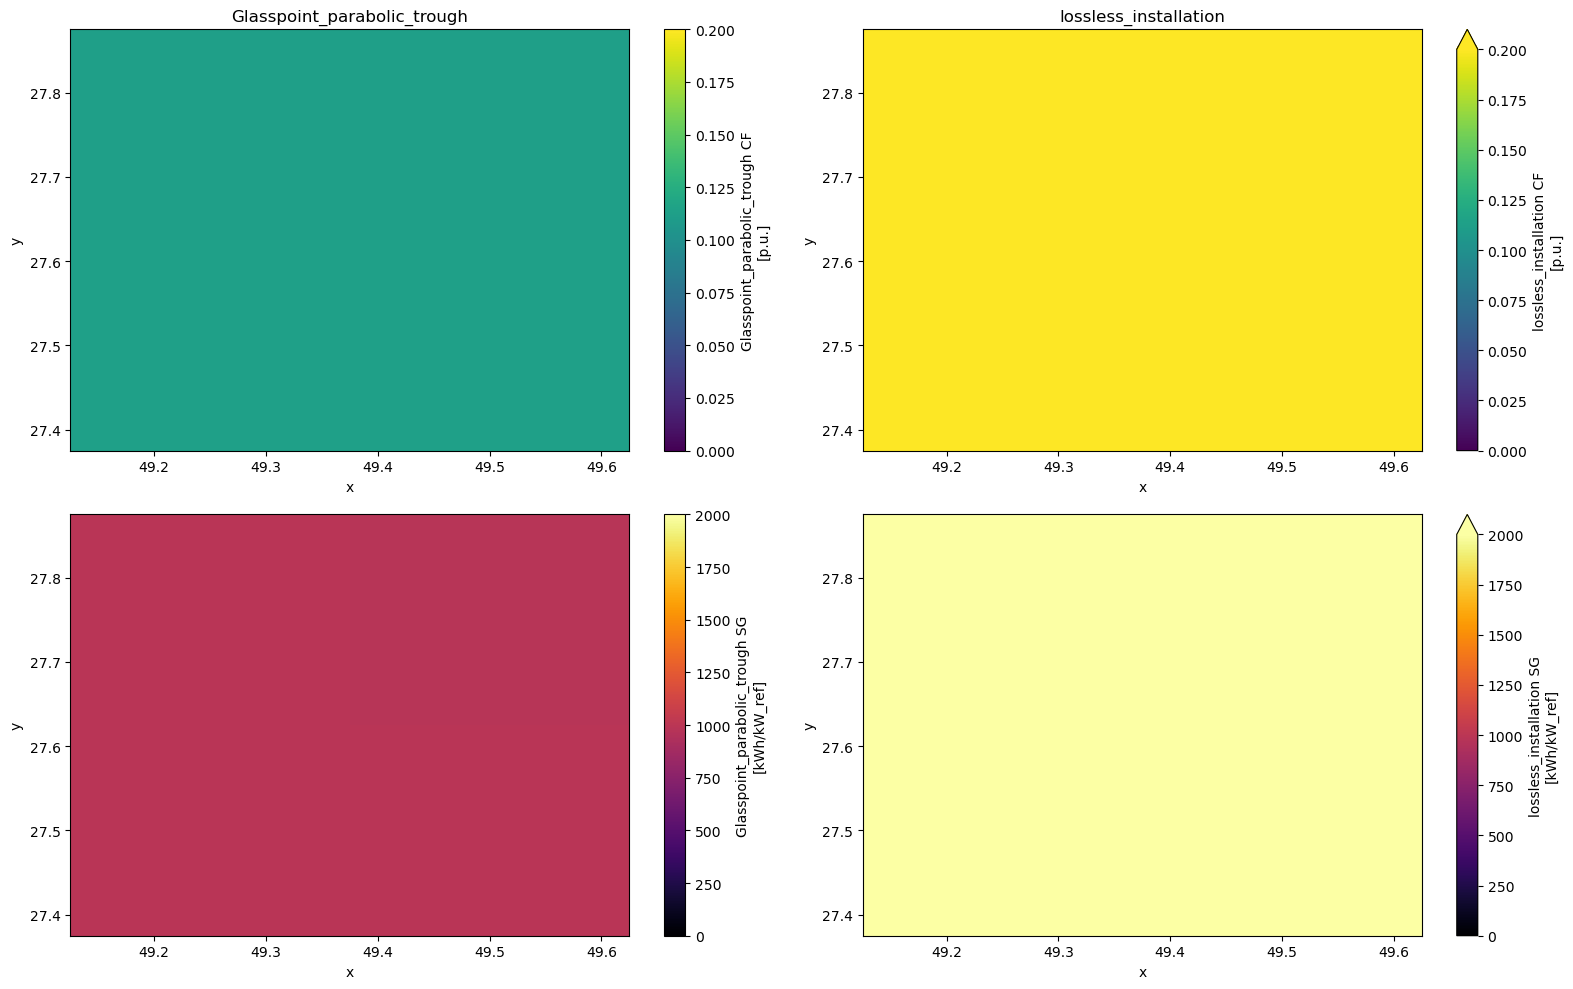

In [4]:
# Plot results side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

pt["capacity factor"].plot(ax=axes[0][0], cmap="viridis", vmin=0, vmax=0.2)
pt["specific generation"].plot(ax=axes[1][0], cmap="inferno", vmin=0, vmax=2000)
axes[0][0].set_title("Glasspoint_parabolic_trough")

ll["capacity factor"].plot(ax=axes[0][1], cmap="viridis", vmin=0, vmax=0.2)
ll["specific generation"].plot(ax=axes[1][1], cmap="inferno", vmin=0, vmax=2000)
axes[0][1].set_title("lossless_installation")

# # Overlay Spanish borders
# for ax in axes.ravel():
#     bounds.plot(ax=ax, fc="none", ec="black")

fig.tight_layout()

In [5]:
# Layout with different installed capacity (due to different SAM model)
config = atlite.resource.get_cspinstallationconfig("SAM_parabolic_trough")
# solar field: from Glasspoint input
area = 240120 # m^2

# installed power = 950 W/m^2 * area = 90.2 MW
installed_power = config["r_irradiance"] * area / 1.0e6
print(installed_power)

# actual Ridgecrest location
location = {"x": 27.503, "y": 49.202}

# Determine location on cutout grid
nearest_location = {
    v: cutout.grid[v].iloc[cutout.grid[v].sub(location[v]).abs().idxmin()]
    for v in ["x", "y"]
}

layout = xr.zeros_like(pt["capacity factor"])
layout.loc[dict(x=nearest_location["x"], y=nearest_location["y"])] = installed_power

228.114


In [6]:

# Extract the concenctrated solar power generation capacity factors
csp_power_generation = cutout.csp(
    technology="glasspoint parabolic trough",
    # installation="Glasspoint_parabolic_trough",
    installation="lossless_installation",
    # installation="SAM_parabolic_trough",
    # installation="SAM_solar_tower",
    # technology="solar tower",
    layout=layout,)

# # Save gridded data as netCDF files
# if not os.path.exists("rasal_khair_csp_CF_timeseries_2018.nc"):
#     csp_power_generation.to_netcdf(f"rasalkhair_csp_CF_timeseries_2018.nc")

In [7]:
csp_power_generation_df = csp_power_generation.to_dataframe()
# Drop dim_0 of index
csp_power_generation_df = csp_power_generation_df.reset_index(level=1, drop=True)
print(csp_power_generation_df)

                     specific generation
time                                    
2018-01-01 00:00:00                  0.0
2018-01-01 01:00:00                  0.0
2018-01-01 02:00:00                  0.0
2018-01-01 03:00:00                  0.0
2018-01-01 04:00:00                  0.0
...                                  ...
2018-12-31 19:00:00                  0.0
2018-12-31 20:00:00                  0.0
2018-12-31 21:00:00                  0.0
2018-12-31 22:00:00                  0.0
2018-12-31 23:00:00                  0.0

[8760 rows x 1 columns]


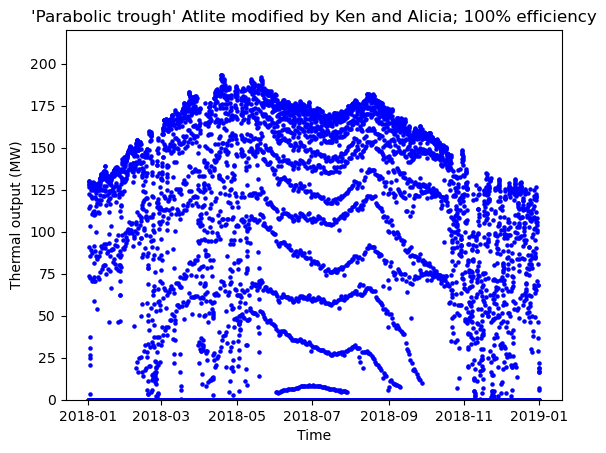

In [8]:
# Cut off all values above 140 MW
# csp_power_generation_df = csp_power_generation_df[csp_power_generation_df["specific generation"] < 140]
# Plot time series of the capacity factor
plt.figure()
plt.scatter(
    csp_power_generation_df.index,
    csp_power_generation_df.values,
    s=5,
    color="blue",
)
# csp_power_generation.sel(time=slice("2018-03-01", "2018-03-07")).plot.line(
#     x="time", hue="dim_0"
# )
# Remove title
plt.title(f"'Parabolic trough' Atlite modified by Ken and Alicia; 100% efficiency")
plt.xlabel("Time")
plt.ylabel("Thermal output (MW)")
plt.ylim(0, 220)
plt.savefig("generation_AtliteMod_100pcEff_cut.png", dpi=400)

In [9]:
csp_power_generation_sol_tower = cutout.csp(
    technology="solar tower",
    installation="lossless_installation",
    layout=layout,)

csp_power_generation_sol_tower = csp_power_generation_sol_tower.to_dataframe()
# Drop dim_0 of index
csp_power_generation_sol_tower = csp_power_generation_sol_tower.reset_index(level=1, drop=True)

# csp_power_generation_sol_tower = csp_power_generation_sol_tower[csp_power_generation_sol_tower["specific generation"] < 140]

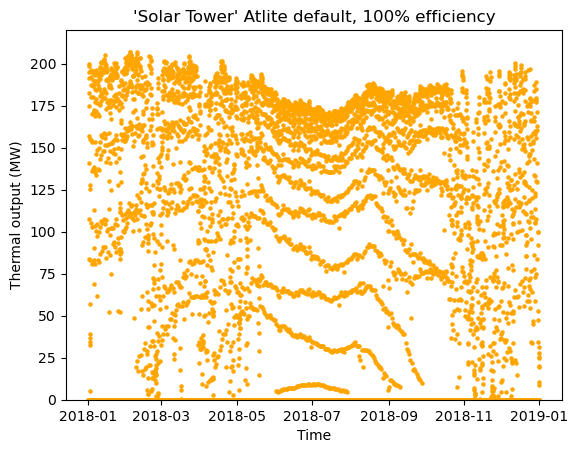

In [10]:
# Plot time series of the capacity factor
plt.figure()
plt.scatter(
    csp_power_generation_sol_tower.index,
    csp_power_generation_sol_tower.values,
    s=5,
    c="orange",
)
# Remove title
plt.title(f"'Solar Tower' Atlite default, 100% efficiency")
plt.xlabel("Time")
plt.ylabel("Thermal output (MW)")
plt.ylim(0, 220)
plt.savefig("generation_Atlite_SolarTower.png", dpi=400)

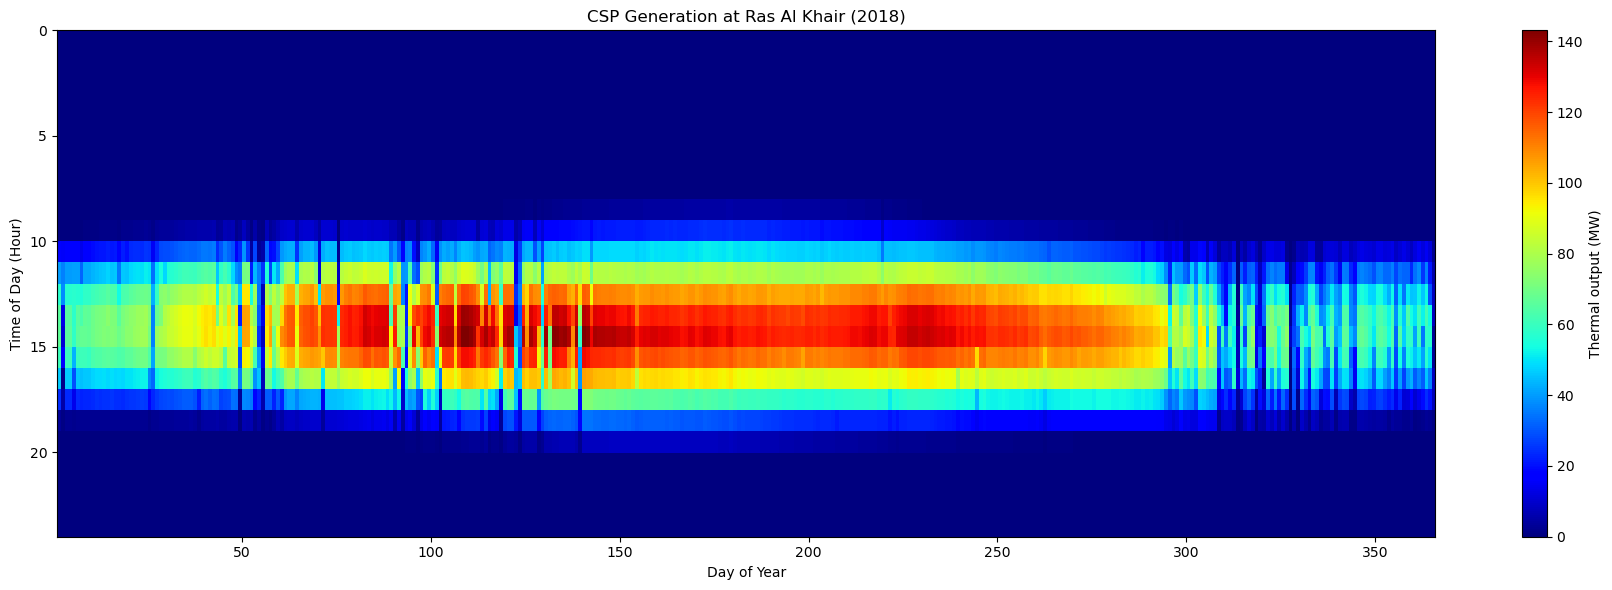

In [11]:
# Load the NetCDF file
file_path = "rasalkhair_csp_CF_timeseries_2018.nc"  # Update path if needed
ds = xr.open_dataset(file_path)

# Extract the CSP generation data
cf = ds["specific generation"]

# Convert to DataFrame
df = cf.to_dataframe().reset_index()

# Convert time column to datetime
df["time"] = pd.to_datetime(df["time"])

# Extract day of year and time of day in fractional hours
df["day_of_year"] = df["time"].dt.dayofyear
# Flip time of day such that 0 is at the top
df["time_of_day"] = (df["time"].dt.hour + df["time"].dt.minute / 60)

# Pivot for heatmap: rows = time of day, columns = day of year
pivot = df.pivot(index="time_of_day", columns="day_of_year", values="specific generation")

# Plot the data
plt.figure(figsize=(18, 6))
plt.imshow(pivot, aspect="auto", origin="lower", cmap="jet",
           extent=[1, 366, 24, 0])
plt.colorbar(label="Thermal output (MW)")
plt.xlabel("Day of Year")
plt.ylabel("Time of Day (Hour)")
plt.title("CSP Generation at Ras Al Khair (2018)")
plt.tight_layout()

In [12]:
# Read in Glasspoint data
glasspoint_data = pd.read_csv("../../../input_files/SAM_glasspoint_data_generation.csv")

# Rename Glasspoint Datetime to time
glasspoint_data.rename(columns={"Datetime": "time", "Annual thermal energy in Year 1 (kWt)":"thermal_output"}, inplace=True)

print(glasspoint_data)

      Day  Hour  thermal_output                 time
0       1     3            0.00  2018-01-01 00:00:00
1       1     4            0.00  2018-01-01 01:00:00
2       1     5            0.00  2018-01-01 02:00:00
3       1     6            0.00  2018-01-01 03:00:00
4       1     7            0.00  2018-01-01 04:00:00
...   ...   ...             ...                  ...
8752  365    19         4815.53  2018-12-31 16:00:00
8753  365    20            0.00  2018-12-31 17:00:00
8754  365    21            0.00  2018-12-31 18:00:00
8755  365    22            0.00  2018-12-31 19:00:00
8756  365    23            0.00  2018-12-31 20:00:00

[8757 rows x 4 columns]


/tmp/ipykernel_3559704/3683352400.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  glasspoint_data = glasspoint_data.groupby("thermal_output_binned").mean().reset_index()


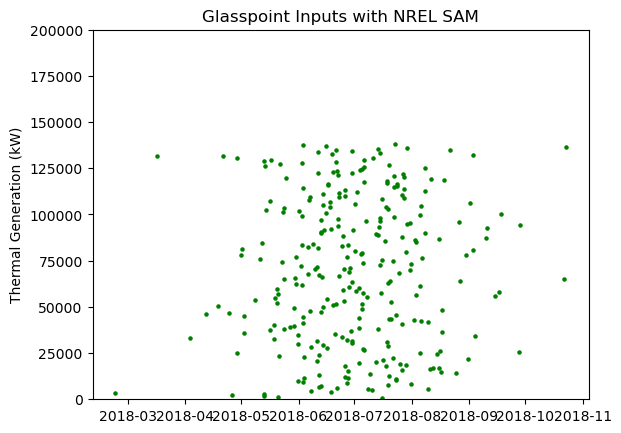

In [ ]:
# Plot Annual Generation vs time
plt.figure()
glasspoint_data["time"] = pd.to_datetime(glasspoint_data["time"])

plt.scatter(
    glasspoint_data.time,
    glasspoint_data["thermal_output"],
    s=5,
    c="green",
)

plt.title("Glasspoint Inputs with NREL SAM")
plt.ylabel("Thermal Generation (kW)")
plt.ylim(0, 200000)
plt.savefig("generation_GP.png", dpi=400)

In [14]:
# Print the hours that are 0
print("Hours with 0 generation:")
pd.set_option("display.max_rows", None)  # Show all rows
print(glasspoint_data[glasspoint_data["thermal_output"] == 0]["time"])

Hours with 0 generation:
Series([], Name: time, dtype: datetime64[ns])


In [15]:
# Cut the last 3 hours of the year
df = df[df["time"] < "2018-12-31 21:00:00"]
print(df)
#save to csv
df.to_csv("rasalkhair_csp_CF_timeseries_2018.csv", index=False)

                    time  dim_0  specific generation  day_of_year  time_of_day
0    2018-01-01 00:00:00      0         0.000000e+00            1          0.0
1    2018-01-01 01:00:00      0         0.000000e+00            1          1.0
2    2018-01-01 02:00:00      0         0.000000e+00            1          2.0
3    2018-01-01 03:00:00      0         0.000000e+00            1          3.0
4    2018-01-01 04:00:00      0         0.000000e+00            1          4.0
5    2018-01-01 05:00:00      0         2.840189e+00            1          5.0
6    2018-01-01 06:00:00      0         2.429070e+01            1          6.0
7    2018-01-01 07:00:00      0         4.690247e+01            1          7.0
8    2018-01-01 08:00:00      0         6.069047e+01            1          8.0
9    2018-01-01 09:00:00      0         6.658960e+01            1          9.0
10   2018-01-01 10:00:00      0         6.574630e+01            1         10.0
11   2018-01-01 11:00:00      0         5.710899e+01

                    time  specific generation  day_of_year  time_of_day  \
0    2018-01-01 00:00:00         0.000000e+00            1          0.0   
1    2018-01-01 01:00:00         0.000000e+00            1          1.0   
2    2018-01-01 02:00:00         0.000000e+00            1          2.0   
3    2018-01-01 03:00:00         0.000000e+00            1          3.0   
4    2018-01-01 04:00:00         0.000000e+00            1          4.0   
5    2018-01-01 05:00:00         2.840189e+00            1          5.0   
6    2018-01-01 06:00:00         2.429070e+01            1          6.0   
7    2018-01-01 07:00:00         4.690247e+01            1          7.0   
8    2018-01-01 08:00:00         6.069047e+01            1          8.0   
9    2018-01-01 09:00:00         6.658960e+01            1          9.0   
10   2018-01-01 10:00:00         6.574630e+01            1         10.0   
11   2018-01-01 11:00:00         5.710899e+01            1         11.0   
12   2018-01-01 12:00:00 

Text(0.5, 1.0, 'CSP Generation Glasspoint/Atlite at Ras Al Khair (2018)')

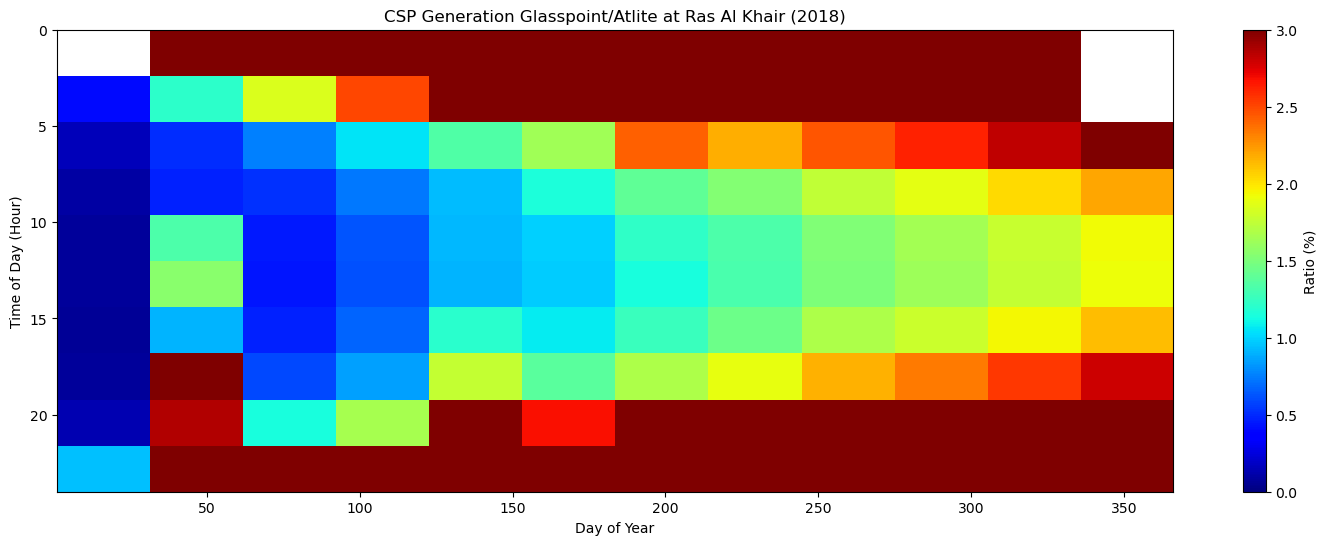

In [16]:
# Make a ratio plot of the Atlite and Glasspoint data showing it as heatmap: 
# 1. Merge the two DataFrames on time

merged_df = pd.concat(
    [
        df[["time", "specific generation", "day_of_year", "time_of_day"]],
        glasspoint_data[["time", "thermal_output"]],
    ],
    axis=1,
)
# 2. Calculate the ratio
merged_df["ratio"] = (
    (merged_df["thermal_output"]/1000) / merged_df["specific generation"]
)

print(merged_df)
# Drop NaN values and infinite values
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna()

# 3. Create a pivot table for the ratio
pivot_ratio = merged_df.pivot(
    index="time_of_day", columns="day_of_year", values="ratio"
)
# 4. Plot the ratio
plt.figure(figsize=(18, 6))
plt.imshow(
    pivot_ratio,
    aspect="auto",
    origin="lower",
    cmap="jet",
    extent=[1, 366, 24, 0],
    vmin=0,
    vmax=3,
)
plt.colorbar(label="Ratio (%)")
plt.xlabel("Day of Year")
plt.ylabel("Time of Day (Hour)")
plt.title("CSP Generation Glasspoint/Atlite at Ras Al Khair (2018)")

ValueError: x and y must be the same size

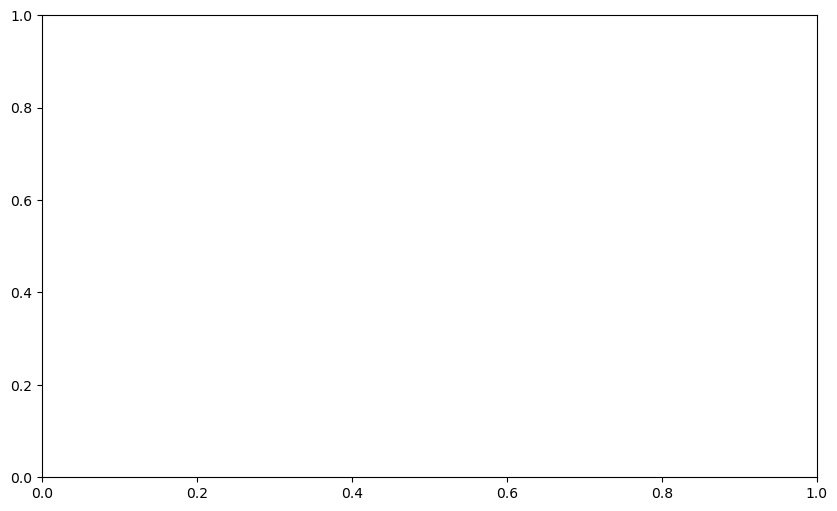

In [17]:
# Make a scatter plot of Glasspoint data vs. atlite data
plt.figure(figsize=(10, 6))
plt.scatter(
    df["specific generation"],
    glasspoint_data["thermal_output"],
    alpha=0.5,
    color="blue",
)
plt.xlabel("Atlite Specific Generation (MW)")
plt.ylabel("Glasspoint Thermal Generation (kW)")

            binned  dim_0  specific generation  day_of_year  time_of_day
0   (-0.001, 10.0]    0.0             0.000000        185.0         16.0
1     (10.0, 20.0]    0.0            14.781667        246.5         10.0
2     (20.0, 30.0]    0.0            24.064022        187.0          8.0
3     (30.0, 40.0]    0.0            33.963974        219.0         10.0
4     (40.0, 50.0]    0.0            46.121965        149.5         12.0
5     (50.0, 60.0]    0.0            54.622558        238.5          7.0
6     (60.0, 70.0]    0.0            64.743375        152.5          9.0
7     (70.0, 80.0]    0.0            76.016225        134.0         10.0
8     (80.0, 90.0]    0.0            84.066455        171.5         10.0
9    (90.0, 100.0]    0.0            94.525409        169.5          8.0
10  (100.0, 110.0]    0.0           106.055516        180.0         11.0
11  (110.0, 120.0]    0.0           114.105704        194.5          9.0
12  (120.0, 130.0]    0.0           125.090435     

Text(0, 0.5, 'Glasspoint Thermal Generation (MW)')

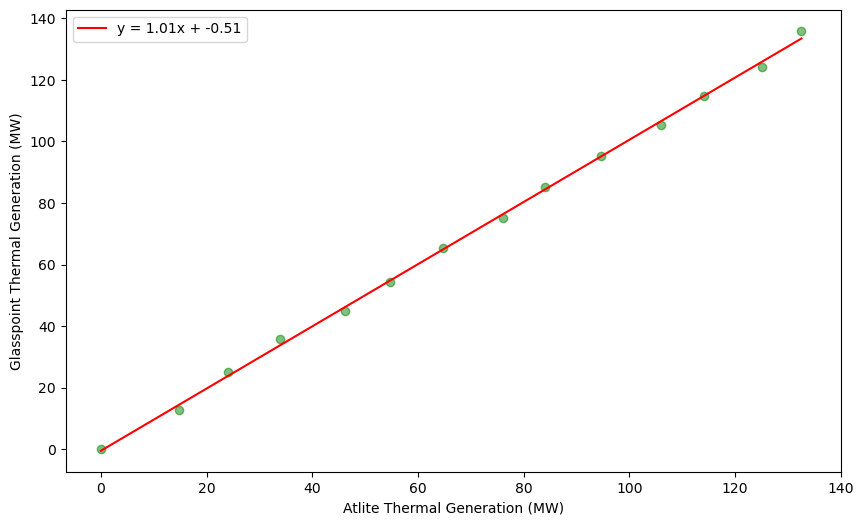

In [ ]:
# Bin width
bin_width = 10

# Rebin df["specific generation"] in 10 MW bins
df["binned"] = pd.cut(
    df["specific generation"],
    bins=np.arange(0, 150, bin_width),
    include_lowest=True,
)

# Group and calculate mean of specific generation (or other desired columns)
binned_data = (
    df.groupby("binned", observed=True)
    .median(numeric_only=True)
    .reset_index()
)

# Rebin glasspoint_data["thermal_output"]
glasspoint_data["binned"] = pd.cut(
    glasspoint_data["thermal_output"],
    bins=np.arange(0, 150000., bin_width*1000),
    include_lowest=True,
)

# Group and calculate mean of relevant columns
binned_glasspoint_data = (
    glasspoint_data.groupby("binned", observed=True)
    .median(numeric_only=True)
    .reset_index()
)
binned_glasspoint_data["thermal_output"] = binned_glasspoint_data["thermal_output"] / 1000 # Convert to MW

print(binned_data)       
print(binned_glasspoint_data)

plt.figure(figsize=(10, 6))
plt.scatter(
    binned_data["specific generation"],
    binned_glasspoint_data["thermal_output"],
    alpha=0.5,
    color="green",
)

# Add a linear fit
m = np.polyfit(
    binned_data["specific generation"], binned_glasspoint_data["thermal_output"], 1
)
b = np.polyval(m, binned_data["specific generation"])
plt.plot(
    binned_data["specific generation"],
    b,
    color="red",
    label=f"y = {m[0]:.2f}x + {m[1]:.2f}",
)
plt.legend()


# Include 140 on x labels
plt.xticks(
    ticks=np.arange(0, 150, 20),
    labels=[str(int(x)) for x in np.arange(0, 150, 20)],
)
plt.xlabel("Atlite Thermal Generation (MW)")
plt.ylabel("Glasspoint Thermal Generation (MW)")
